<a href="https://colab.research.google.com/github/Sobia-Qaiser/Machine-Learning-Tasks/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)

In [3]:
# Replace 'Telco-Customer-Churn.csv' with your CSV filepath
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Quick look
print("Shape:", df.shape)
df

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# 2.1 Drop exact duplicate rows if any
duplicates = df.duplicated().sum()
print("Duplicates:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()
    print("Dropped duplicates. New shape:", df.shape)

Duplicates: 0


In [5]:
# 2.2 Fix TotalCharges: it may be read as object due to blank spaces
# Convert to numeric, coercing errors to NaN, then fill or drop those rows
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
# Count missing TotalCharges
missing_total = df['TotalCharges'].isna().sum()
print("Missing TotalCharges:", missing_total)

Missing TotalCharges: 11


In [7]:
# If small number of missing values (e.g., customers with tenure 0), fill with 0 or MonthlyCharges*tenure
# We'll fill with 0 if tenure==0, otherwise with MonthlyCharges * tenure as reasonable guess
mask_zero_tenure = (df['TotalCharges'].isna()) & (df['tenure'] == 0)
df.loc[mask_zero_tenure, 'TotalCharges'] = 0.0

mask_other = (df['TotalCharges'].isna()) & (df['tenure'] > 0)
df.loc[mask_other, 'TotalCharges'] = df.loc[mask_other, 'MonthlyCharges'] * df.loc[mask_other, 'tenure']


In [8]:
# Confirm no missing TotalCharges now
print("Missing TotalCharges after fill:", df['TotalCharges'].isna().sum())

Missing TotalCharges after fill: 0


In [9]:
# 2.3 Check other missing values
print("Missing by column:\n", df.isna().sum())

Missing by column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [10]:
# 2.4 Remove customerID column (identifier, not a feature)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

In [11]:
# Convert 'Churn' to binary 0/1
df['Churn_flag'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [12]:
# 3.1 Gender-wise churn rate
gender_churn = df.groupby('gender')['Churn_flag'].mean().reset_index()
print("Gender churn rate:\n", gender_churn)

Gender churn rate:
    gender  Churn_flag
0  Female    0.269209
1    Male    0.261603


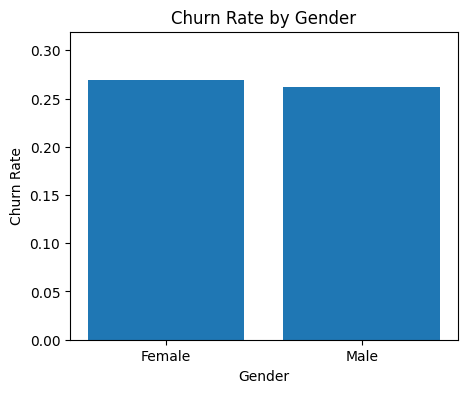

In [13]:
# Plot gender-wise churn
plt.figure(figsize=(5,4))
plt.bar(gender_churn['gender'], gender_churn['Churn_flag'])
plt.title('Churn Rate by Gender')
plt.ylabel('Churn Rate')
plt.xlabel('Gender')
plt.ylim(0, gender_churn['Churn_flag'].max() + 0.05)
plt.show()

Tenure bucket churn:
   TenureBucket  Churn_flag
0          0-3    0.562147
1         4-12    0.391459
2        13-24    0.287109
3        25-48    0.203890
4        49-72    0.095132
5          73+         NaN


/tmp/ipython-input-3270931305.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('TenureBucket')['Churn_flag'].mean().reset_index()


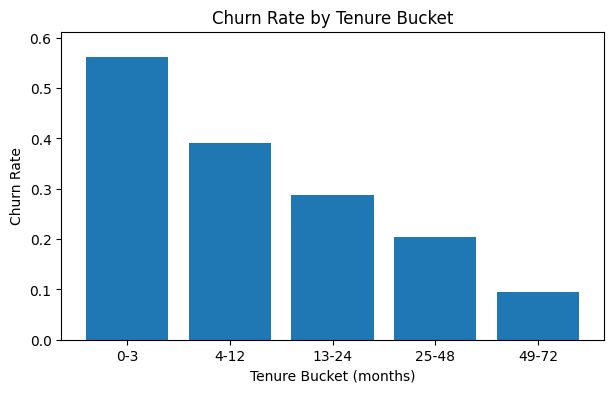

In [14]:
# 3.2 Tenure vs churn: create tenure buckets
df['TenureBucket'] = pd.cut(df['tenure'], bins=[-1,3,12,24,48,72,100],
                           labels=['0-3','4-12','13-24','25-48','49-72','73+'])
tenure_churn = df.groupby('TenureBucket')['Churn_flag'].mean().reset_index()
print("Tenure bucket churn:\n", tenure_churn)

plt.figure(figsize=(7,4))
plt.bar(tenure_churn['TenureBucket'].astype(str), tenure_churn['Churn_flag'])
plt.title('Churn Rate by Tenure Bucket')
plt.xlabel('Tenure Bucket (months)')
plt.ylabel('Churn Rate')
plt.ylim(0, tenure_churn['Churn_flag'].max() + 0.05)
plt.show()

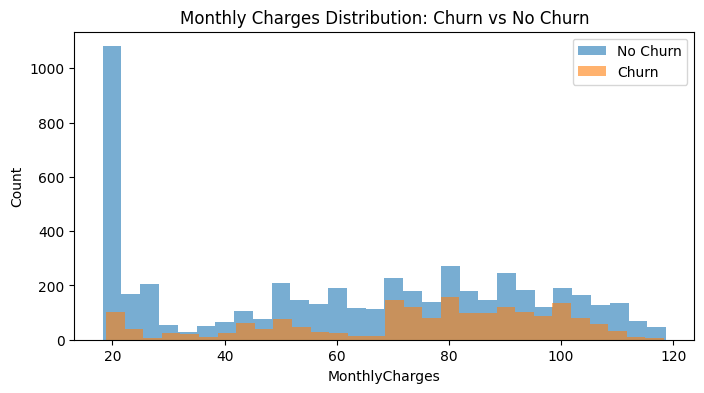

In [15]:
# 3.3 Monthly charges distribution for churn vs not-churn
plt.figure(figsize=(8,4))
plt.hist(df[df['Churn_flag']==0]['MonthlyCharges'], bins=30, alpha=0.6, label='No Churn')
plt.hist(df[df['Churn_flag']==1]['MonthlyCharges'], bins=30, alpha=0.6, label='Churn')
plt.title('Monthly Charges Distribution: Churn vs No Churn')
plt.xlabel('MonthlyCharges')
plt.ylabel('Count')
plt.legend()
plt.show()

In [16]:
# 3.4 Quick correlation for numeric features with churn
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
corrs = df[numeric_cols + ['Churn_flag']].corr()['Churn_flag'].sort_values(ascending=False)
print("Correlation with churn:\n", corrs)

Correlation with churn:
 Churn_flag        1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn_flag, dtype: float64


In [17]:
# 4.1 Simplify objects like 'No internet service' or 'No phone service' -> treat as 'No'
# Many features contain 'No internet service' or 'No phone service'
replace_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                'StreamingTV','StreamingMovies','MultipleLines']
for c in replace_cols:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service': 'No', 'No phone service': 'No'})

In [18]:
# 4.2 Select feature columns
# Drop original 'Churn' and helper TenureBucket; use Churn_flag as target
target = 'Churn_flag'
drop_cols = ['Churn', 'TenureBucket']  # TenureBucket was for EDA only
X = df.drop(columns=[target] + drop_cols)
y = df[target]

In [19]:
# 4.3 Identify numeric and categorical columns
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
cat_features = [c for c in X.columns if c not in num_features]

print("Numeric features:", num_features)
print("Categorical features:", cat_features[:20])

Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [22]:
# 4.4 Build preprocessing pipeline
# - OneHotEncode categorical (drop='first' to avoid dummy trap optionally)
# - Scale numeric features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'  # drop other cols if any
)


In [23]:
# 5) Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (5634, 19) Test size: (1409, 19)


In [24]:
# 6.1 Logistic Regression pipeline
log_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# 6.2 Random Forest pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

In [25]:
# 7) Fit models
# -----------------------------
print("Training Logistic Regression...")
log_pipe.fit(X_train, y_train)

print("Training Random Forest...")
rf_pipe.fit(X_train, y_train)

Training Logistic Regression...
Training Random Forest...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [27]:
def evaluate_model(pipeline, X_test, y_test, label="Model"):
    y_pred = pipeline.predict(X_test)
    y_proba = None
    try:
        y_proba = pipeline.predict_proba(X_test)[:,1]
    except:
        pass

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"--- {label} ---")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    if auc is not None:
        print("ROC AUC:", round(auc,4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return {'model': label, 'accuracy': acc, 'precision': prec, 'recall': rec, 'roc_auc': auc}

results = []
results.append(evaluate_model(log_pipe, X_test, y_test, label="Logistic Regression"))
results.append(evaluate_model(rf_pipe, X_test, y_test, label="Random Forest"))

--- Logistic Regression ---
Accuracy: 0.8048
Precision: 0.6562
Recall: 0.5561
ROC AUC: 0.8424
Confusion Matrix:
 [[926 109]
 [166 208]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

--- Random Forest ---
Accuracy: 0.7793
Precision: 0.6061
Recall: 0.4813
ROC AUC: 0.8219
Confusion Matrix:
 [[918 117]
 [194 180]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [28]:
# 9) Compare results in a dataframe
# -----------------------------
res_df = pd.DataFrame(results).set_index('model')
print("\nModel comparison:\n", res_df)


Model comparison:
                      accuracy  precision    recall   roc_auc
model                                                       
Logistic Regression  0.804826   0.656151  0.556150  0.842370
Random Forest        0.779276   0.606061  0.481283  0.821885
